In [1]:
%load_ext autoreload
%autoreload 2

In [45]:
import vmo.generate as vge
import pretty_midi
import numpy as np
import librosa
import matplotlib.pyplot as plt
import vmo
import sklearn.preprocessing as pre
import music21 
from vmo.VMO.utility.distances.tonnetz import distance as tonnetz
import vmo.plot as vplot
import vmo.analysis.hmm as hmm
import copy
import string
import pickle

np.set_printoptions(precision=4, suppress=True)

%matplotlib inline

In [3]:
midi_path = "../midi_vmo_improvisation/experiment/midi/Now's_The_Time_1.MID"
midi_data = pretty_midi.PrettyMIDI(midi_path)
piece = midi_path.split('/')[-1][:-4]
fs = midi_data.resolution

In [4]:
piano_matrix = midi_data.get_piano_roll(fs=fs)
midi_chroma = midi_data.get_chroma(fs=fs)

In [5]:
beat_num = 4
beats_time = midi_data.get_beats()
bar_time = [beats_time[i] for i in range(0,len(beats_time),beat_num)]
bar_time = np.append(bar_time, midi_data.get_end_time())
beats = np.floor(beats_time*fs).astype(int)
bars = [beats[i] for i in range(0,len(beats),beat_num)]

In [6]:
bar_chroma = librosa.util.sync(pre.minmax_scale(midi_chroma, axis=1), bars, aggregate=np.max)+np.finfo(float).eps

In [7]:
bar_chroma = bar_chroma.T[2:,:].T

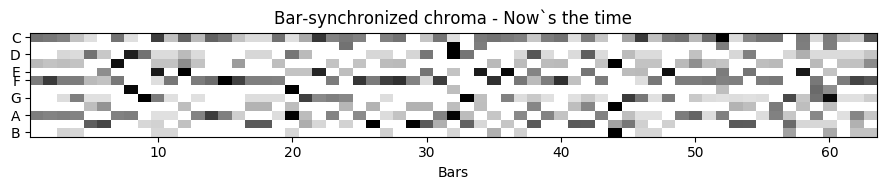

In [8]:
plt.figure(figsize=(9, 2))
plt.imshow(bar_chroma, aspect='auto', interpolation='nearest', cmap='Greys')
plt.title('Bar-synchronized chroma - Now`s the time')
plt.yticks([0,2,4,5,7,9,11], ['C','D','E','F','G','A','B'])
plt.xticks(range(9,60,10),range(10,70,10))
plt.xlabel('Bars')
plt.tight_layout()
plt.savefig('midi_chroma.pdf')

In [9]:
# Build target oracle
r = (0, 1.01, 0.005)
bar_threshold = vmo.find_threshold(bar_chroma.T, r=r, dim=12, dfunc='other', dfunc_handle=tonnetz)

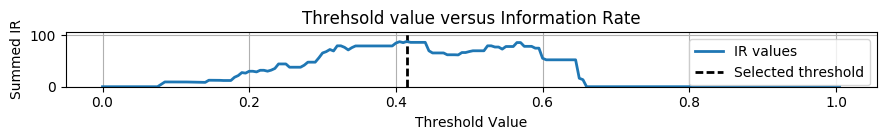

In [10]:
ideal_bar_t = bar_threshold[0][1]
bar_vmo = vmo.build_oracle(bar_chroma.T, flag='a', threshold=ideal_bar_t, dim=12, dfunc='other', dfunc_handle=tonnetz)

x_t = [i[1] for i in bar_threshold[1]]
y_t = [i[0] for i in bar_threshold[1]]

plt.figure(figsize=(9,1.5))
plt.plot(x_t, y_t, linewidth = 2)
plt.vlines(ideal_bar_t, 0.0, 1.2*np.max(y_t), colors='k',linestyle = 'dashed', linewidth = 2)
plt.grid('on')
plt.legend(['IR values', 'Selected threshold'], loc=1)
plt.title('Threhsold value versus Information Rate')
plt.xlabel('Threshold Value')
plt.ylabel('Summed IR')
plt.ylim([0,1.2*np.max(y_t)])
plt.tight_layout()

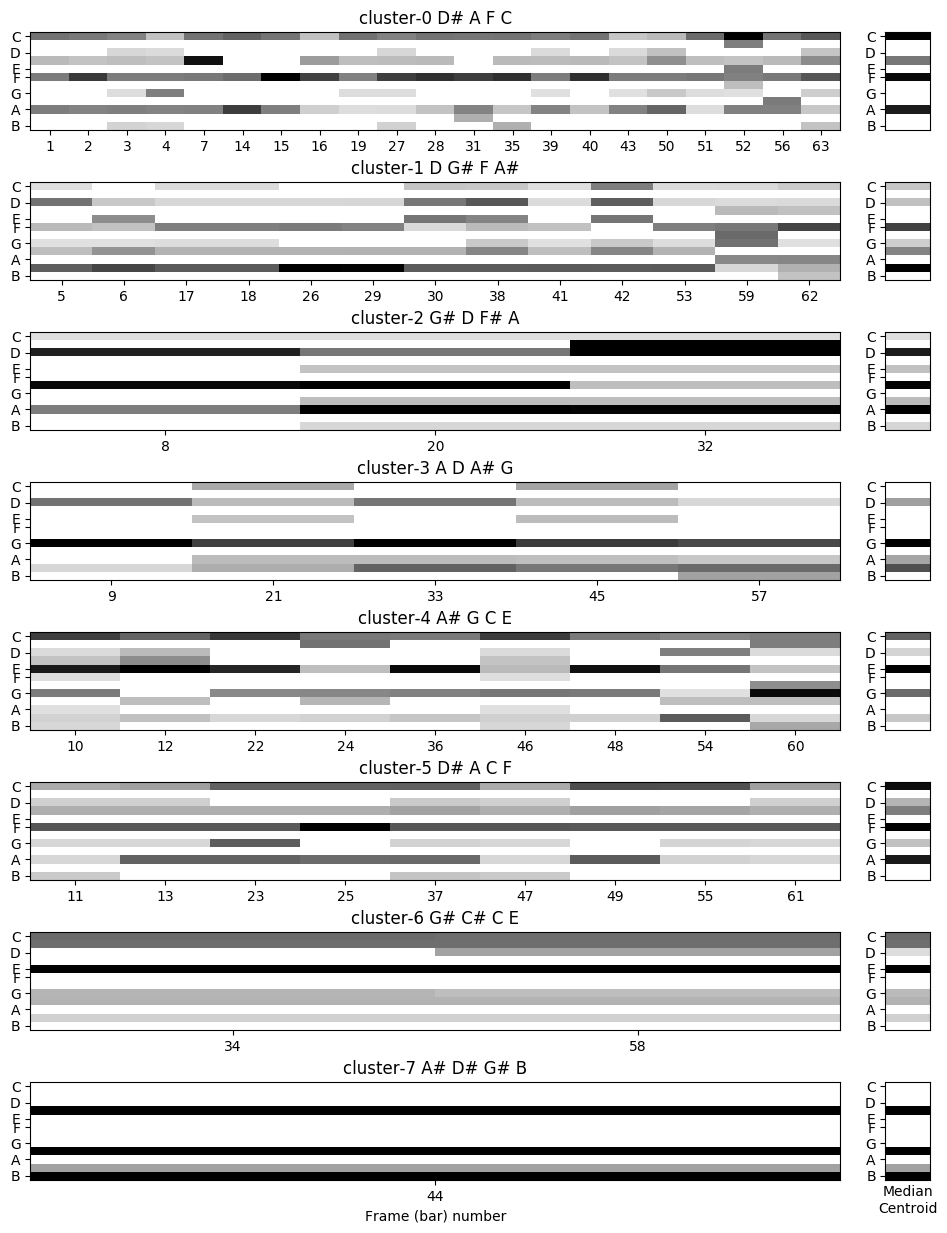

In [11]:
chord_list = []

fig = plt.figure(figsize=(9, 1.5*len(bar_vmo.latent)))

for i,c in enumerate(bar_vmo.latent):
    cluster_mat = bar_chroma.T[np.array(c)-1]
#     fig = plt.subplot(1, len(bar_vmo.latent),i+1)
#     fig = plt.figure(figsize=(9,1))
    ax1 = fig.add_axes([0., float(len(bar_vmo.latent)-i-1)/len(bar_vmo.latent), 0.9, (.65)/len(bar_vmo.latent)])
    ax2 = fig.add_axes([0.95, float(len(bar_vmo.latent)-i-1)/len(bar_vmo.latent), 0.05, (.65)/len(bar_vmo.latent)])
    cluster_mean = np.median(bar_vmo.f_array.data[np.array(c),:].T, axis=1)
    
    chroma = vplot.plot_chroma_as_chord(cluster_mean, n_pitch=4)
    chord_list.append(chroma)
    ax1.imshow(cluster_mat.T, aspect='auto', interpolation='nearest', cmap='Greys')
    ax1.set_yticks([0,2,4,5,7,9,11])
    ax1.set_yticklabels(['C','D','E','F','G','A','B'])
    ax1.set_xticks(range(len(c)))
    ax1.set_xticklabels(c)
    if i == len(bar_vmo.latent)-1:
        ax1.set_xlabel('Frame (bar) number')
        ax2.set_xlabel('Median\nCentroid')
    ax1.set_title("cluster-"+str(i)+" "+str(" ".join(chroma.pitchNames)))
    ax2.imshow(cluster_mean.reshape((1,-1)).T, aspect='auto', interpolation='nearest', cmap='Greys')
    ax2.set_yticks([0,2,4,5,7,9,11])
    ax2.set_yticklabels(['C','D','E','F','G','A','B'])    
    ax2.set_xticks([])
fig.savefig('cluster.pdf')

In [12]:
xml_path = "../midi_vmo_improvisation/experiment/xml/"+piece+'.xml'
xml_data = music21.converter.parse(xml_path)

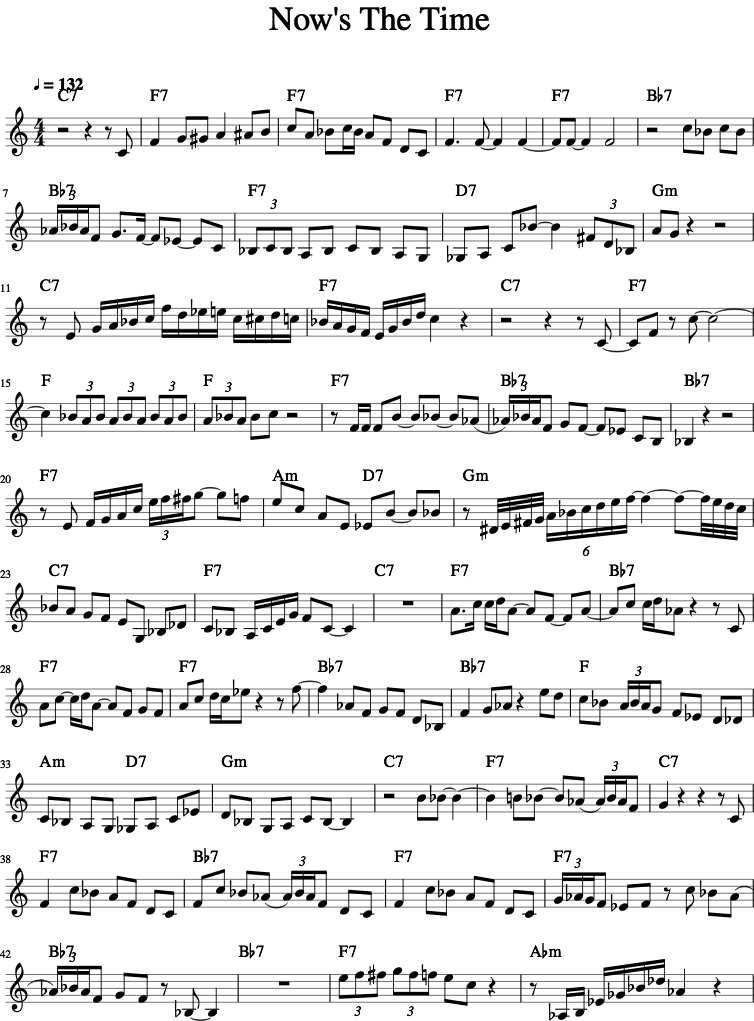

In [13]:
xml_data.show()

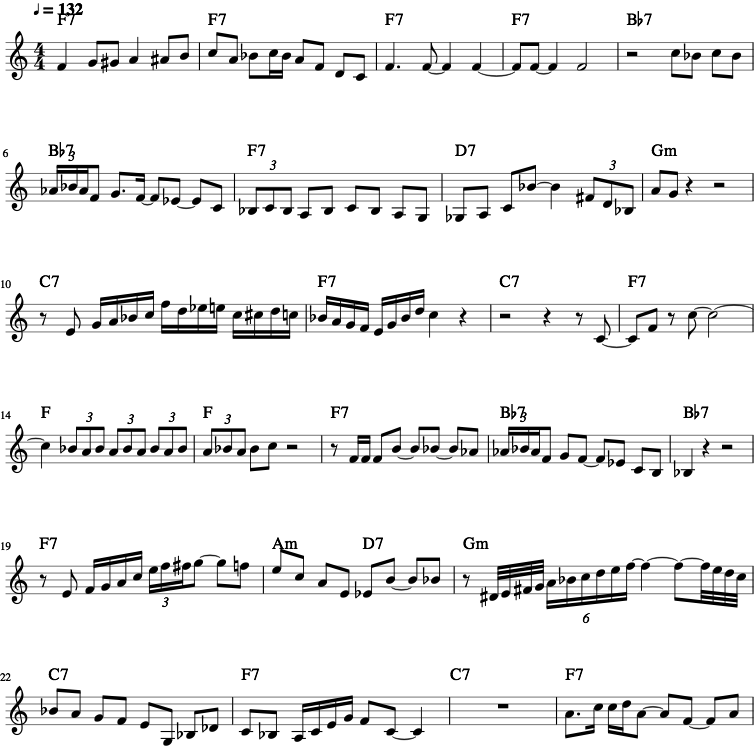

In [14]:
xml_path = "../midi_vmo_improvisation/experiment/xml/"+piece+'.xml'
xml_data = music21.converter.parse(xml_path)
s = music21.stream.Stream()
f = xml_data.getElementsByClass('Part')[0].getElementsByClass('Measure')[0]
for i,m in enumerate(xml_data.getElementsByClass('Part')[0].getElementsByClass('Measure')[1:26]):
    s.append(m)
for e in f.elements[1:5]:
    s[0].insert(0,e)

s.show()

In [15]:
hmm_tensor = vmo.analysis.hmm.extract_hmm_tensor(bar_vmo, smooth=False)

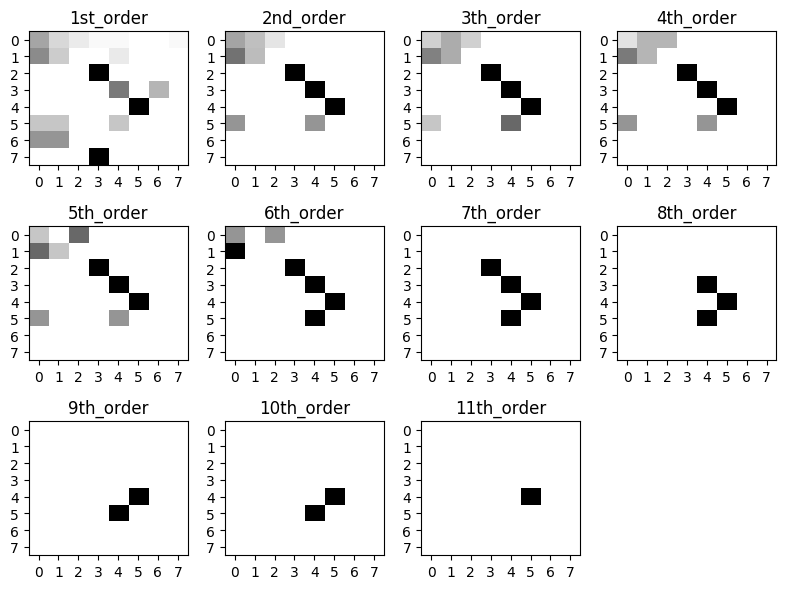

In [16]:
plt.figure(figsize=(8,2*np.ceil(len(hmm_tensor)/4.0)))
for i in range(int(len(hmm_tensor))):
    plt.subplot(np.ceil(len(hmm_tensor)/4.0),4,i+1)
    if i == 0:
        plt.title('1st_order')                
    elif i ==1:
        plt.title('2nd_order')        
    else:
        plt.title(str(i+1)+'th_order')
    plt.xticks(range(len(bar_vmo.latent)))
    plt.yticks(range(len(bar_vmo.latent)))
    plt.imshow(hmm_tensor[i], interpolation='nearest', aspect='auto', cmap='Greys')
    plt.tight_layout()

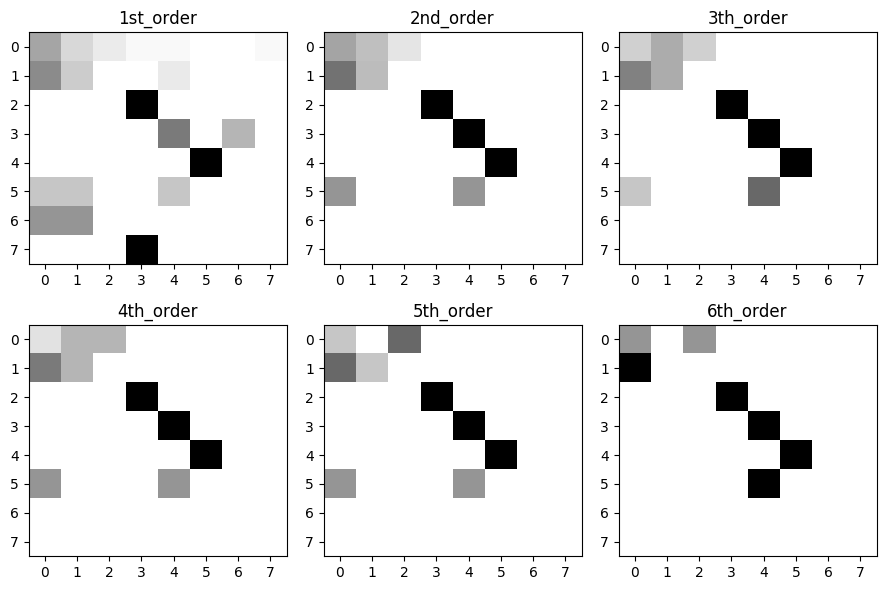

In [17]:
plt.figure(figsize=(9,6))
for i in range(6):
    plt.subplot(2,3,i+1)
    if i == 0:
        plt.title('1st_order')                
    elif i ==1:
        plt.title('2nd_order')        
    else:
        plt.title(str(i+1)+'th_order')
    plt.xticks(range(len(bar_vmo.latent)))
    plt.yticks(range(len(bar_vmo.latent)))
    plt.imshow(hmm_tensor[i], interpolation='nearest', aspect='auto', cmap='Greys')
plt.tight_layout()
plt.savefig('matrices.pdf')

## Random Walk

In [81]:
steps = 13
rnd_walk_seqs = []
bar_walk_seqs = []

bar_time_tmp = bar_time[2:]

for order in range(6):
    seq = [0]
    bars = pretty_midi.PrettyMIDI(resolution=midi_data.resolution, initial_tempo=midi_data.get_tempo_changes()[1])
    bars.key_signature_changes = midi_data.key_signature_changes
    m = bar_vmo.latent[seq[0]][0]
    
    bar_seq = [m]
    start = bar_time_tmp[m-1]
    ending = bar_time_tmp[m]

    for instrument in midi_data.instruments:
        if not instrument.is_drum:
            bars.instruments.append(copy.deepcopy(instrument))
            bars.instruments[-1].notes=[]
            for n in instrument.notes:
                if n.start >= start and n.start < ending:
                    new_note = pretty_midi.Note(n.velocity, n.pitch, 
                                                n.start-start+bar_time[0],
                                                n.end-start+bar_time[0]
                                               )
                    bars.instruments[-1].notes.append(new_note)
            
    for i in range(1, steps):
        next_state = np.argmax(np.random.multinomial(1, hmm_tensor[order][seq[-1]]))
        seq.append(next_state)
        if (m+1) in bar_vmo.latent[seq[-1]]:
            m+=1
        else:
            m = np.random.choice(bar_vmo.latent[seq[-1]])
        bar_seq.append(m)
        start = bar_time_tmp[m-1]
        ending = bar_time_tmp[m]
        
        inst_ind=0
        for instrument in midi_data.instruments:
            if not instrument.is_drum:
                for n in instrument.notes:
                    if n.start >= start and n.start < ending:
                        new_note = pretty_midi.Note(n.velocity, n.pitch, 
                                                    n.start-start+bar_time[i],
                                                    n.end-start+bar_time[i]
                                                   )
                        bars.instruments[inst_ind].notes.append(new_note)
                inst_ind+=1
                        
    rnd_walk_seqs.append(seq)
    bar_walk_seqs.append(bar_seq)
    bars.write('out/'+piece+'_order_'+str(order+1)+'_rnd_walk.mid')

In [82]:
print rnd_walk_seqs[0]
print rnd_walk_seqs[4]

[0, 0, 0, 3, 6, 0, 2, 3, 6, 1, 4, 5, 4]
[0, 0, 2, 3, 4, 5, 0, 2, 3, 4, 5, 4, 5]


In [83]:
cluster_dict = dict(
                    [(0,'F7'),
                     (1,'Bb7'),
                     (2,'D7'),
                     (3,'Gm'),
                     (4,'C7'),
                     (5,'F7($\sharp$11)'),
                     (6,'C7($\flat$9)')]
                    )
# print rnd_walk_seqs[0]
# print rnd_walk_seqs[4]

c_str = '$\mid$ '
for i,s in enumerate(rnd_walk_seqs[0]):
    c_str+=(cluster_dict[s]+' $\mid$ ')
print c_str

$\mid$ F7 $\mid$ F7 $\mid$ F7 $\mid$ Gm $\mid$ C7($lat$9) $\mid$ F7 $\mid$ D7 $\mid$ Gm $\mid$ C7($lat$9) $\mid$ Bb7 $\mid$ C7 $\mid$ F7($\sharp$11) $\mid$ C7 $\mid$ 


In [40]:
print cluster_dict

{0: 'F/F7', 1: 'Bb7', 2: 'D7', 3: 'Gm', 4: 'C7', 5: 'F13(#11)', 6: 'C7(b9)'}


## Query-Guided

### Create fake guide

In [108]:
pitch_class = ['C','D-','D','E-','E','F','G-','G','A-','A','B-','B']
major = [1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0.]
major7= [1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1.]
domin7= [1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0.]
augmen= [1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0.]
minor = [1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0.]
minor7= [1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0.]
dimini= [1., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0.]
mnflt7= [1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0.]

chord_type = {'':major, 
              '7':domin7, 
              'm':minor, 
              'm7':minor7, 
              'dim':dimini, 
              '/o7':mnflt7,
              '+':augmen,
             }


In [109]:
def chord_to_chroma(chord):
    if "-" in chord:    
        offset = pitch_class.index(chord[:2])
        c_type = chord[2:] 
    else:
        offset = pitch_class.index(chord[0])
        c_type = chord[1:]
    return np.roll(chord_type[c_type], offset)


In [110]:
query_chroma = []
for i,m in enumerate(xml_data.getElementsByClass('Part')[0].getElementsByClass('Measure')[1:25]):
    ch = m.getElementsByClass("ChordSymbol")[0]
    query_chroma.append(chord_to_chroma(ch.figure))
    

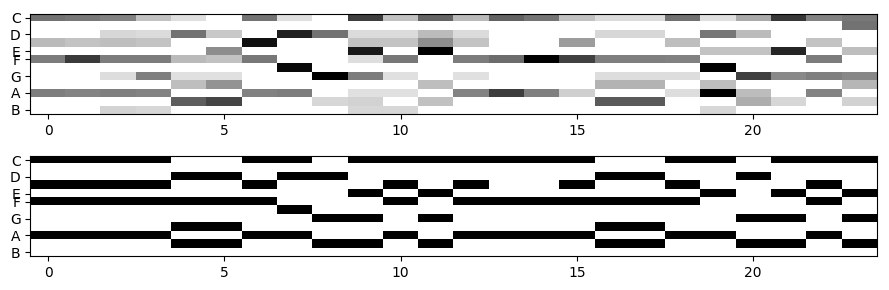

In [111]:
plt.figure(figsize=(9,3))
plt.subplot(211)
plt.imshow(bar_chroma.T[:24].T, interpolation='nearest', aspect='auto', cmap='Greys')
plt.yticks([0,2,4,5,7,9,11], ['C','D','E','F','G','A','B'])
plt.subplot(212)
plt.imshow(np.array(query_chroma).T, interpolation='nearest', aspect='auto', cmap='Greys')
plt.yticks([0,2,4,5,7,9,11], ['C','D','E','F','G','A','B'])
plt.tight_layout()

In [116]:
v,p = hmm.recognition(query_chroma, bar_vmo, order=1)

In [117]:
print p

[[ 0.  0.  0.  0.  5.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  1.  1.  1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.  1.  1.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  2.  2.  2.  2.  2.]
 [ 3.  3.  3.  3.  3.  3.  3.  3.]
 [ 4.  4.  4.  4.  4.  4.  4.  4.]
 [ 5.  5.  5.  5.  5.  5.  5.  5.]
 [ 4.  4.  4.  4.  4.  4.  4.  4.]
 [ 5.  5.  5.  5.  5.  5.  5.  5.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  1.  1.  1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.  1.  1.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  2.  0.  4.  0.  0.]
 [ 1.  3.  3.  3.  3.  3.  3.  3.]
 [ 4.  4.  4.  4.  4.  4.  4.  4.]
 [ 5.  5.  5.  5.  5.  5.  5.  5.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]]


In [118]:
print np.argsort(v[-1])
print v[-1]

[7 2 5 0 6 1 3 4]
[-48.3169 -47.7883 -49.3219 -47.7789 -47.1655 -48.5226 -47.7949 -49.379 ]


In [119]:
for _p, d in zip(p.T[np.argmax(v[-1])], bar_vmo.data[1:62]):
    print int(_p), d

5 0
0 0
0 0
0 0
1 1
1 1
0 0
2 2
3 3
4 4
5 5
4 4
5 5
0 0
0 0
0 0
1 1
1 1
0 0
0 2
3 3
4 4
5 5
0 4


## Cluster Visualization

In [25]:
cluster_means = [np.median(bar_vmo.f_array.data[np.array(c),:].T, axis=1) for c in bar_vmo.latent]

In [26]:
cluster_means

[array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]),
 array([ 0.623 ,  0.    ,  0.    ,  0.3774,  0.    ,  0.6056,  0.    ,
         0.    ,  0.    ,  0.5642,  0.    ,  0.    ]),
 array([ 0.2381,  0.    ,  0.2608,  0.    ,  0.    ,  0.4781,  0.    ,
         0.2118,  0.4027,  0.    ,  0.717 ,  0.    ]),
 array([ 0.2183,  0.    ,  0.8879,  0.    ,  0.3459,  0.    ,  0.9664,
         0.    ,  0.3691,  0.9805,  0.    ,  0.2582]),
 array([ 0.    ,  0.    ,  0.3793,  0.    ,  0.    ,  0.    ,  0.    ,
         0.8092,  0.    ,  0.3658,  0.6085,  0.    ]),
 array([ 0.6409,  0.    ,  0.1185,  0.    ,  0.8931,  0.    ,  0.    ,
         0.563 ,  0.    ,  0.    ,  0.2877,  0.    ]),
 array([ 0.5675,  0.    ,  0.2371,  0.3459,  0.    ,  0.5936,  0.    ,
         0.2099,  0.    ,  0.5409,  0.    ,  0.    ]),
 array([ 0.5952,  0.5851,  0.2091,  0.    ,  0.9088,  0.    ,  0.    ,
         0.3511,  0.3691,  0.    ,  0.2594,  0.    ]),
 array([ 0.    ,  0.    ,  0.    ,  1.    ,  0. 